# NFL Combine Analysis
## 2010-2020

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.stats import levene
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Load Data:

### Import NFL Combine results from 2010-2020

In [2]:
combine10 = pd.read_csv("Files\combine2010.csv")
combine11 = pd.read_csv("Files\combine2011.csv")
combine12 = pd.read_csv("Files\combine2012.csv")
combine13 = pd.read_csv("Files\combine2013.csv")
combine14 = pd.read_csv("Files\combine2014.csv")
combine15 = pd.read_csv("Files\combine2015.csv")
combine16 = pd.read_csv("Files\combine2016.csv")
combine17 = pd.read_csv("Files\combine2017.csv")
combine18 = pd.read_csv("Files\combine2018.csv")
combine19 = pd.read_csv("Files\combine2019.csv")
combine20 = pd.read_csv("Files\combine2020.csv")

### Join all the results into one dataframe, rename columns, and get rid of the "College" column 

In [3]:
df = pd.concat([combine12,combine13,combine14,combine15,combine16,combine17,combine18,combine18,combine20])
df.columns = ['Player', 'Position', 'School', 'College', 'Height', 'Weight', '40Yard', 'Vertical', 
              'Bench', 'Broad', '3Cone', 'Shuttle', 'Drafted']
del df['College']

### Drop duplicate rows

In [4]:
df = df.drop_duplicates(subset = "Player")

## Data Exploration:

###  Check position levels

In [5]:
df.Position.value_counts()

WR      377
CB      289
RB      238
DT      181
OT      175
DE      172
OLB     155
TE      142
QB      137
OG      126
ILB     102
SS       75
FS       62
C        60
OL       54
S        53
P        52
LB       47
DL       46
K        35
FB       26
EDGE     23
LS       10
NT        3
DB        2
Name: Position, dtype: int64

### Remove DB and NT for insufficient data (DB's are either CB or FS/SS anyway)

In [6]:
df = df[df.Position != 'DB']
df = df[df.Position != 'NT']

### Get number and percent of missing values by column

In [7]:
df.isnull().sum().sort_values(ascending=False)

3Cone       1028
Shuttle      971
Drafted      903
Bench        747
Broad        587
Vertical     552
40Yard       202
Weight         0
Height         0
School         0
Position       0
Player         0
dtype: int64

In [8]:
(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

3Cone       0.389837
Shuttle     0.368221
Drafted     0.342435
Bench       0.283276
Broad       0.222601
Vertical    0.209329
40Yard      0.076602
Weight      0.000000
Height      0.000000
School      0.000000
Position    0.000000
Player      0.000000
dtype: float64

### Check descriptive statistics and correlation matrix

In [9]:
df.describe()

,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle
count,2637.000000,2435.000000,2085.000000,1890.000000,2050.000000,1609.000000,1666.000000
mean,242.424346,4.773860,32.714149,20.054497,115.697073,7.255923,4.406573
std,45.047884,0.298383,4.180123,6.399998,9.230916,0.407333,0.263399
min,156.000000,4.220000,17.500000,3.000000,82.000000,6.280000,3.810000
25%,205.000000,4.540000,30.000000,15.000000,110.000000,6.960000,4.210000
50%,232.000000,4.690000,33.000000,20.000000,117.000000,7.160000,4.360000
75%,277.000000,4.960000,35.500000,24.000000,122.000000,7.500000,4.560000
max,369.000000,5.850000,45.000000,44.000000,147.000000,8.720000,5.380000


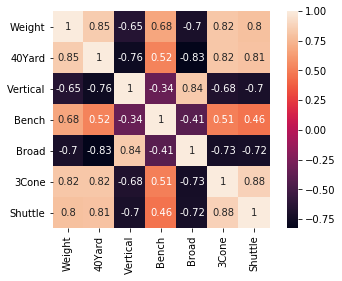

In [10]:
sns.heatmap(df.corr(), annot=True, square=True)

### Check unique values by column

In [11]:
df.apply(pd.Series.nunique).sort_values(ascending=False)

Player      2637
Drafted     1734
School       234
3Cone        192
Weight       190
40Yard       140
Shuttle      130
Broad         56
Vertical      54
Bench         39
Position      23
Height        18
dtype: int64

### Check position group numbers before imputation

In [12]:
df.groupby('Position').count()

,Player,School,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted
Position,,,,,,,,,,,
C,60,60,60,60,56,44,50,43,42,43,37
CB,289,289,289,289,276,234,227,232,172,179,202
DE,172,172,172,172,165,141,136,139,123,124,126
DL,46,46,46,46,38,32,38,29,27,26,36
DT,181,181,181,181,172,141,142,138,127,129,132
EDGE,23,23,23,23,19,17,17,18,11,12,13
FB,26,26,26,26,25,21,22,21,19,19,13
FS,62,62,62,62,58,49,50,49,39,38,41
ILB,102,102,102,102,91,81,82,81,53,60,68


In [13]:
df.groupby('Position').median()

,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle
Position,,,,,,,
C,305.5,5.240,26.50,25.0,102.0,7.750,4.700
CB,193.0,4.500,35.50,15.0,122.0,6.935,4.180
DE,269.0,4.830,32.50,23.0,116.0,7.250,4.415
DL,289.5,4.900,30.25,24.0,114.0,7.470,4.520
DT,307.0,5.070,29.00,28.0,105.0,7.680,4.630
EDGE,251.0,4.760,33.00,23.0,119.0,7.140,4.280
FB,240.5,4.750,33.00,23.5,115.0,7.240,4.340
FS,206.5,4.580,35.00,16.0,121.0,7.010,4.185
ILB,240.0,4.760,32.50,20.5,117.0,7.150,4.315


## Data Cleaning:

### Kickers and punters are missing most of their testing data so removing

In [14]:
df = df[df.Position != 'K']
df = df[df.Position != 'P']

### Delete rows where athlete missed > 2 tests

In [15]:
df = df.dropna(subset = ['40Yard', 'Vertical', 'Bench', 'Broad', '3Cone', 'Shuttle'], thresh = 4)

### Imputate with their position medians

In [16]:
df['40Yard'] = df['40Yard'].fillna(df.groupby('Position')['40Yard'].transform('median'))
df['Vertical'] = df['Vertical'].fillna(df.groupby('Position')['Vertical'].transform('median'))
df['Bench'] = df['Bench'].fillna(df.groupby('Position')['Bench'].transform('median'))
df['Broad'] = df['Broad'].fillna(df.groupby('Position')['Broad'].transform('median'))
df['3Cone'] = df['3Cone'].fillna(df.groupby('Position')['3Cone'].transform('median'))
df['Shuttle'] = df['Shuttle'].fillna(df.groupby('Position')['Shuttle'].transform('median'))

### Clean up the athlete's name column

In [17]:
df[['Name', 'ID']] = df.Player.apply(lambda x: pd.Series(str(x).split("\\")))
del df['Player']

### Convert height to inches for analysis (from 6-2 format into 74)

In [18]:
df[['Feet','Inches']] = df['Height'].str.split('-', 1, expand=True)
df.Feet = df.Feet.astype(int)
df.Inches = df.Inches.astype(int)
df['Height'] = (12 * df['Feet']) + df['Inches']

### Turn the "Drafted" column binary for classification

In [19]:
df['Drafted'] = df['Drafted'].notnull().astype(int)

### One hot encode the "Position" column

In [20]:
dfohe = pd.concat([pd.get_dummies(df['Position']), df], axis = 1)
dfohe = dfohe.drop(['Feet', 'Inches', 'Position', 'ID'], axis = 1)

### Get numerical columns for normalization

In [21]:
normCols = ['Height', 'Weight', '40Yard', 'Vertical', 'Bench', 'Broad', '3Cone', 'Shuttle']
dfnorm = df[normCols]

### Normalize

In [22]:
dfnorm=(dfnorm-dfnorm.mean())/dfnorm.std()

### Join dataframes from above

In [23]:
dfclean = pd.concat([dfohe.drop(normCols, axis=1), dfnorm], axis = 1)
dfclean = dfclean.dropna()

## Data Preparation:

### Get feature variables for machine learning

In [24]:
x = dfclean.drop(['School', 'Name', 'Drafted'], axis = 1)
X = x.values

### Get target variable for machine learning

In [25]:
y = dfclean.Drafted
Y = y.values

### Initialize machine learning models

In [26]:
logreg = LogisticRegression(random_state = 24)
rf = RandomForestClassifier(random_state = 24)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors = 3)

### Create lists for the model accuracies

In [27]:
logacc = []
rfacc = []
gnbacc = []
knnacc = []

### Create lists for the model FPR's

In [28]:
logfpr = []
rffpr = []
gnbfpr = []
knnfpr = []

## Data Analysis:

### Start 10-Fold Cross-Validation

_Prints out a confusion matrix, the TPR/TNR/FNR/FPR, and the accuracy. The top-right value in the confusion matrix are athletes we predicted not to get drafted and were actually drafted i.e. false positives)_

In [29]:
kf = KFold(n_splits=10)
for k, (train, test) in enumerate(kf.split(X, Y)):
    
    # Logistic Regression
    print("\n")
    print("===== Logistic Regression =====")
    logreg.fit(X[train], Y[train])
    logpred = logreg.predict(X[test])
    logcm = confusion_matrix(Y[test], logpred)
    logtn,logfp,logfn,logtp = logcm.ravel()
    print("Sensitivity: " + str(round(logtp/(logtp+logfn),2)))
    print("Specificity: " + str(round(logtn/(logtn+logfp),2)))
    print("False Negative Rate: " + str(round(logfn/(logfn+logtp),2)))
    print("False Positive Rate: " + str(round(logfp/(logfp+logtn),2)))
    print(logcm)
    logf = logfp/(logfp+logtn)
    loga = metrics.accuracy_score(Y[test], logpred)
    logfpr.append(logf)
    logacc.append(loga)
    print("Accuracy:", round(metrics.accuracy_score(Y[test], logpred),2))
    
    # Random Forest
    print("\n")
    print("===== Random Forest =====")
    rf.fit(X[train], Y[train])
    rfpred = rf.predict(X[test])
    rfcm = confusion_matrix(Y[test], rfpred)
    rftn,rffp,rffn,rftp = rfcm.ravel()
    print("Sensitivity: " + str(round(rftp/(rftp+rffn),2)))
    print("Specificity: " + str(round(rftn/(rftn+rffp),2)))
    print("False Negative Rate: " + str(round(rffn/(rffn+rftp),2)))
    print("False Positive Rate: " + str(round(rffp/(rffp+rftn),2)))
    print(rfcm)
    rff = rffp/(rffp+rftn)
    rfa = metrics.accuracy_score(Y[test], rfpred)
    rffpr.append(rff)
    rfacc.append(rfa)
    print("Accuracy:", round(metrics.accuracy_score(Y[test], rfpred),2))
    
    # Naive Bayes
    print("\n")
    print("===== Naive Bayes =====")
    gnb.fit(X[train], Y[train])
    gnbpred = gnb.predict(X[test])
    gnbcm = confusion_matrix(Y[test], gnbpred)
    gnbtn,gnbfp,gnbfn,gnbtp = gnbcm.ravel()
    print("Sensitivity: " + str(round(gnbtp/(gnbtp+gnbfn),2)))
    print("Specificity: " + str(round(gnbtn/(gnbtn+gnbfp),2)))
    print("False Negative Rate: " + str(round(gnbfn/(gnbfn+gnbtp),2)))
    print("False Positive Rate: " + str(round(gnbfp/(gnbfp+gnbtn),2)))
    print(gnbcm)
    gnbf = gnbfp/(gnbfp+gnbtn)
    gnba = metrics.accuracy_score(Y[test], gnbpred)
    gnbfpr.append(gnbf)
    gnbacc.append(gnba)
    print("Accuracy:", round(metrics.accuracy_score(Y[test], gnbpred),2))
    
    # KNN
    print("\n")
    print("===== K-Nearest Neighbors =====")
    knn.fit(X[train], Y[train])
    knnpred = knn.predict(X[test])
    knncm = confusion_matrix(Y[test], knnpred)
    knntn,knnfp,knnfn,knntp = knncm.ravel()
    print("Sensitivity: " + str(round(knntp/(knntp+knnfn),2)))
    print("Specificity: " + str(round(knntn/(knntn+knnfp),2)))
    print("False Negative Rate: " + str(round(knnfn/(knnfn+knntp),2)))
    print("False Positive Rate: " + str(round(knnfp/(knnfp+knntn),2)))
    print(knncm)
    knnf = knnfp/(knnfp+knntn)
    knna = metrics.accuracy_score(Y[test], knnpred)
    knnfpr.append(knnf)
    knnacc.append(knna)
    print("Accuracy:", round(metrics.accuracy_score(Y[test], knnpred),2))



===== Logistic Regression =====
Sensitivity: 0.98
Specificity: 0.12
False Negative Rate: 0.02
False Positive Rate: 0.88
[[  8  60]
 [  3 124]]
Accuracy: 0.68


===== Random Forest =====
Sensitivity: 0.96
Specificity: 0.22
False Negative Rate: 0.04
False Positive Rate: 0.78
[[ 15  53]
 [  5 122]]
Accuracy: 0.7


===== Naive Bayes =====
Sensitivity: 0.8
Specificity: 0.26
False Negative Rate: 0.2
False Positive Rate: 0.74
[[ 18  50]
 [ 26 101]]
Accuracy: 0.61


===== K-Nearest Neighbors =====
Sensitivity: 0.83
Specificity: 0.34
False Negative Rate: 0.17
False Positive Rate: 0.66
[[ 23  45]
 [ 21 106]]
Accuracy: 0.66


===== Logistic Regression =====
Sensitivity: 0.92
Specificity: 0.38
False Negative Rate: 0.08
False Positive Rate: 0.62
[[ 23  38]
 [ 11 123]]
Accuracy: 0.75


===== Random Forest =====
Sensitivity: 0.91
Specificity: 0.36
False Negative Rate: 0.09
False Positive Rate: 0.64
[[ 22  39]
 [ 12 122]]
Accuracy: 0.74


===== Naive Bayes =====
Sensitivity: 0.75
Specificity: 0.41
F

#### For this classification problem I would say that predicting someone will be drafted and then they don't get drafted is worse than the opposite occuring. In other words, we care more about false positives than false negatives and want to reduce these as much as possible.

#### _Note: I am going to stick with accuracy for significance testing as I feel this does an overall better evaluation of a model. It is important to know that FPR may be a better metric to use in production if we are worried about saying someone will be drafted and then they don't get drafted._

## Data Evaluation:

### Display the mean accuracies for each model over all the folds

In [30]:
logmean = np.mean(logacc)
rfmean = np.mean(rfacc)
gnbmean = np.mean(gnbacc)
knnmean = np.mean(knnacc)

print("Logistic Regression Cross-Validation Mean: " + str(logmean.round(3)))
print("Random Forest Cross-Validation Mean: " + str(rfmean.round(3)))
print("Naive Bayes Cross-Validation Mean: " + str(gnbmean.round(3)))
print("KNN Cross-Validation Mean: " + str(knnmean.round(3)))

Logistic Regression Cross-Validation Mean: 0.708
Random Forest Cross-Validation Mean: 0.703
Naive Bayes Cross-Validation Mean: 0.599
KNN Cross-Validation Mean: 0.663


### Make dataframe for model comparison using accuracy and significance testing 

In [31]:
resultlist = np.asarray(logacc + rfacc + gnbacc + knnacc, dtype = np.float32)
testlist = np.repeat(np.array(["LogisticRegression", "RandomForest", "NaiveBayes", "KNN"]), 10)
resultdf = pd.DataFrame({"Model": testlist, "Accuracy": resultlist})

### Make dataframe for model comparison using FPR

In [32]:
resultlist2 = np.asarray(logfpr + rffpr + gnbfpr + knnfpr, dtype = np.float32)
testlist2 = np.repeat(np.array(["LogisticRegression", "RandomForest", "NaiveBayes", "KNN"]), 10)
resultdf2 = pd.DataFrame({"Model": testlist2, "FPR": resultlist2})

### Compare model accuracies from cross-validation

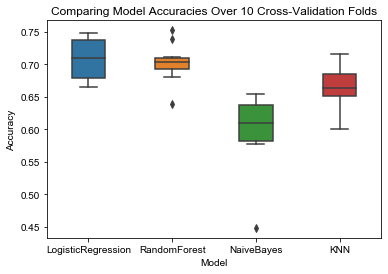

In [33]:
sns.boxplot(x = resultdf['Model'], y = resultdf['Accuracy'], width = 0.4)
sns.set(rc={'figure.figsize':(12,8.27)})
plt.title("Comparing Model Accuracies Over 10 Cross-Validation Folds")
plt.show()

### Compare model FPR from cross-validation

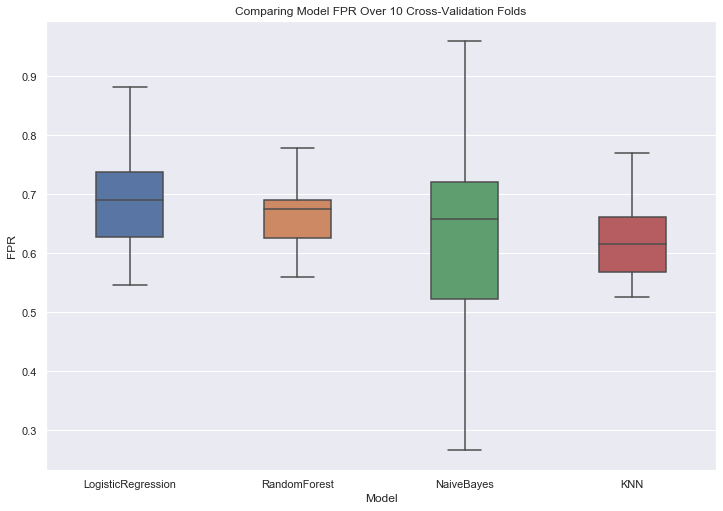

In [34]:
sns.boxplot(x = resultdf2['Model'], y = resultdf2['FPR'], width = 0.4)
sns.set(rc={'figure.figsize':(12,8.27)})
plt.title("Comparing Model FPR Over 10 Cross-Validation Folds")
plt.show()

#### It looks like KNN does a better job at avoiding the misclassification of drafted athletes (FPR) as mentioned above

### Start significance testing

In [35]:
# Levene's Test
levenep = levene(logacc, rfacc, gnbacc, knnacc)[1]

# Run ANOVA if No Violation
if levenep > 0.05:
    anova = f_oneway(logacc, rfacc, gnbacc, knnacc)[1]
    
    # Run Tukey's Test if Significant to Find Which Group(s) Differs
    if anova < 0.05:
      
        # Tukey
        print(pairwise_tukeyhsd(resultdf['Accuracy'], resultdf['Model']))

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
               KNN LogisticRegression   0.0447 0.0925 -0.0052  0.0947  False
               KNN         NaiveBayes  -0.0639 0.0076 -0.1138  -0.014   True
               KNN       RandomForest   0.0401 0.1533 -0.0098    0.09  False
LogisticRegression         NaiveBayes  -0.1086  0.001 -0.1585 -0.0587   True
LogisticRegression       RandomForest  -0.0046    0.9 -0.0546  0.0453  False
        NaiveBayes       RandomForest    0.104  0.001  0.0541  0.1539   True
----------------------------------------------------------------------------


#### It looks like KNN vs. NaiveBayes, Logistic Regression vs. Naive Bayes, and Naive Bayes vs. Random Forest are significantly different. Knowing this and the model mean accuracies over all the folds, either Logistic Regression or Random Forest would be considered the best model.

### Display most important features for Random Forest model

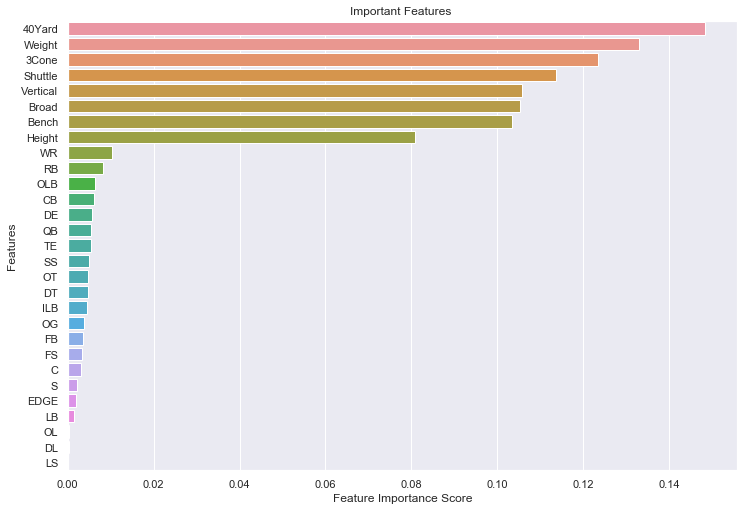

In [36]:
feature_imp = pd.Series(rf.feature_importances_, index = x.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
sns.set(rc={'figure.figsize':(12,8.27)})
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features ")
plt.show()

#### 40-yard dash is very important to being draft, along with an athlete's weight and 3-cone time.